In [19]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [20]:
RANDOM_STATE = 42

# Read Data

In [21]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [22]:
read_query = make_read_query()

In [23]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,n_orders,n_order_items,revenue,purchased_categories,created_at,first_purchase_date,last_purchase_date
0,61226,30,M,United States,Mesquite,Search,0,0,0.00,[None],2021-12-06 08:35:00,NaT,NaT
1,15498,16,M,United States,Lincoln,Organic,1,1,25.00,[Sleep & Lounge],2024-01-14 04:24:00,2024-01-15 00:49:47,2024-01-15 00:49:47
2,41490,61,M,United States,Murrayville,Search,0,0,0.00,[None],2021-07-05 07:54:00,NaT,NaT
3,84974,18,M,China,Chengdu,Search,10,20,1035.38,"[Sweaters, Underwear, Pants, Socks, Outerwear ...",2021-06-17 17:55:00,2022-08-30 18:03:20,2024-01-09 16:21:17
4,98865,44,M,United States,Pharr,Search,1,1,259.99,[Suits & Sport Coats],2020-11-25 02:09:00,2023-11-29 23:31:26,2023-11-29 23:31:26


In [24]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    84011 non-null  int64         
 1   age                   84011 non-null  int64         
 2   gender                84011 non-null  object        
 3   country               84011 non-null  object        
 4   city                  84011 non-null  object        
 5   traffic_source        84011 non-null  object        
 6   n_orders              84011 non-null  int64         
 7   n_order_items         84011 non-null  int64         
 8   revenue               84011 non-null  float64       
 9   purchased_categories  84011 non-null  object        
 10  created_at            84011 non-null  datetime64[ns]
 11  first_purchase_date   69073 non-null  datetime64[ns]
 12  last_purchase_date    69073 non-null  datetime64[ns]
dtypes: datetime64[ns

In [25]:
users_enriched.describe()

,id,age,n_orders,n_order_items,revenue,created_at,first_purchase_date,last_purchase_date
count,84011.000000,84011.000000,84011.000000,84011.000000,84011.000000,84011,69073,69073
mean,50059.769102,41.059897,4.412886,7.370951,439.676297,2021-06-14 10:42:19.902129920,2022-07-16 08:15:15.045710336,2023-01-26 22:31:06.887599104
min,1.000000,12.000000,0.000000,0.000000,0.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-07 01:23:18
25%,25094.500000,26.000000,1.000000,1.000000,22.000000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 16:38:29
50%,50125.000000,41.000000,2.000000,2.000000,108.400000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 21:57:37
75%,75022.500000,56.000000,5.000000,9.000000,455.980000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-09 01:02:14
max,100000.000000,70.000000,155.000000,270.000000,17963.080000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 18:02:23.533893
std,28861.594335,17.047718,6.805672,12.909895,867.696928,NaN,NaN,NaN


In [26]:
inactive_users = users_enriched.loc[users_enriched.first_purchase_date.isna()]
active_users = users_enriched.dropna(subset='first_purchase_date')

In [27]:
inactive_users.shape, active_users.shape

((14938, 13), (69073, 13))

# Utility Functions

In [28]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

In [29]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []        
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)
        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia if inertia else cost
        }
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [30]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

# Clustering

In [31]:
now = active_users.last_purchase_date.max()
now

Timestamp('2024-01-21 18:02:23.533893')

In [35]:
df_lifetime = active_users.copy()
df_lifetime['active_days'] = (df_lifetime.last_purchase_date - df_lifetime.first_purchase_date).dt.days + 1
df_lifetime['inactive_days'] = (now - df_lifetime.last_purchase_date).dt.days
df_lifetime.loc[df_lifetime.n_orders>1, 'avg_days_to_order'] = df_lifetime['active_days'] / (df_lifetime['n_orders'] - 1)
df_lifetime.loc[df_lifetime.n_orders==1, 'avg_days_to_order'] = 1
df_lifetime['items_per_order'] = df_lifetime['n_order_items'] / df_lifetime['n_orders']
df_lifetime['avg_order_value'] = df_lifetime['revenue'] / df_lifetime['n_orders']
df_lifetime = df_lifetime[['active_days', 'inactive_days', 'avg_days_to_order', 'items_per_order', 'avg_order_value']]

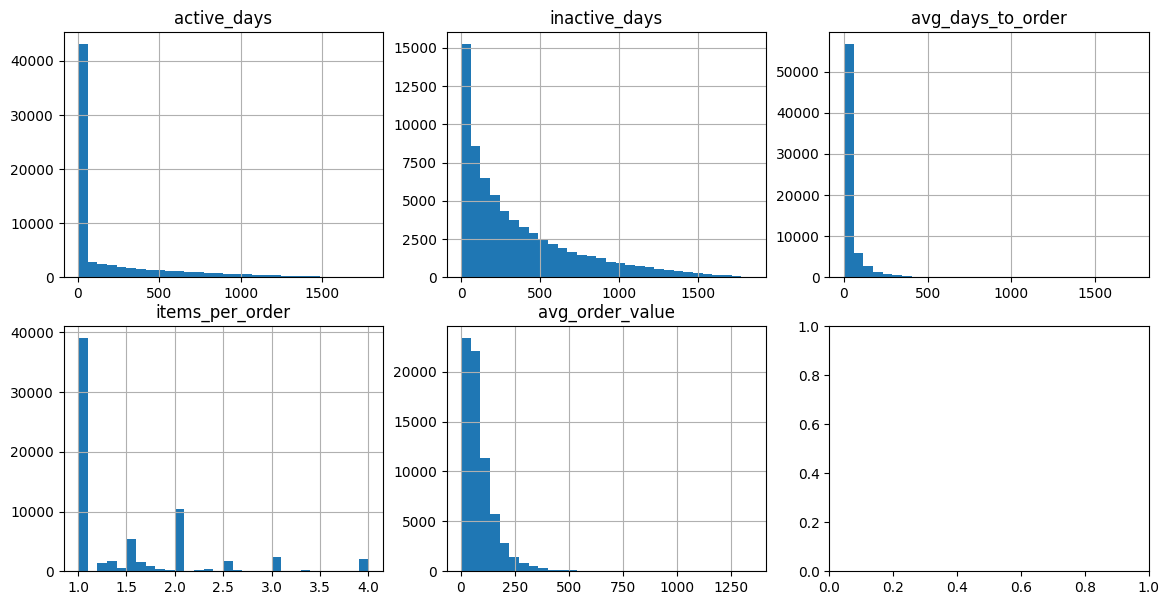

In [36]:
plot_histograms(df_lifetime, bins=30)

<Axes: >

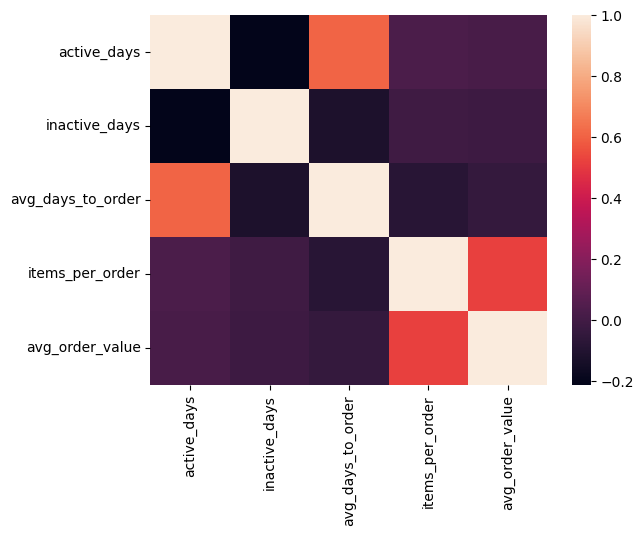

In [37]:
sns.heatmap(df_lifetime.corr())

In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(df_lifetime)

In [39]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
df_results = search_clustering_hyperparams(KMeans, hyperparams, X, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.34146635324386215 | Inertia: 277103.0937575456
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.38905256597933807 | Inertia: 201717.72626844348
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.36958479539216554 | Inertia: 176458.1187242039
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.35759208963643424 | Inertia: 137256.6869847036
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.33379189031268874 | Inertia: 121741.40803661474
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.32624948149915245 | Inertia: 115022.57656000525
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.28318382515524626 | Inertia: 105175.33847707493
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.28987171476149987 | Inertia: 94078.30726379472
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.2927738335720683 | Inertia: 88961.9991997038


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

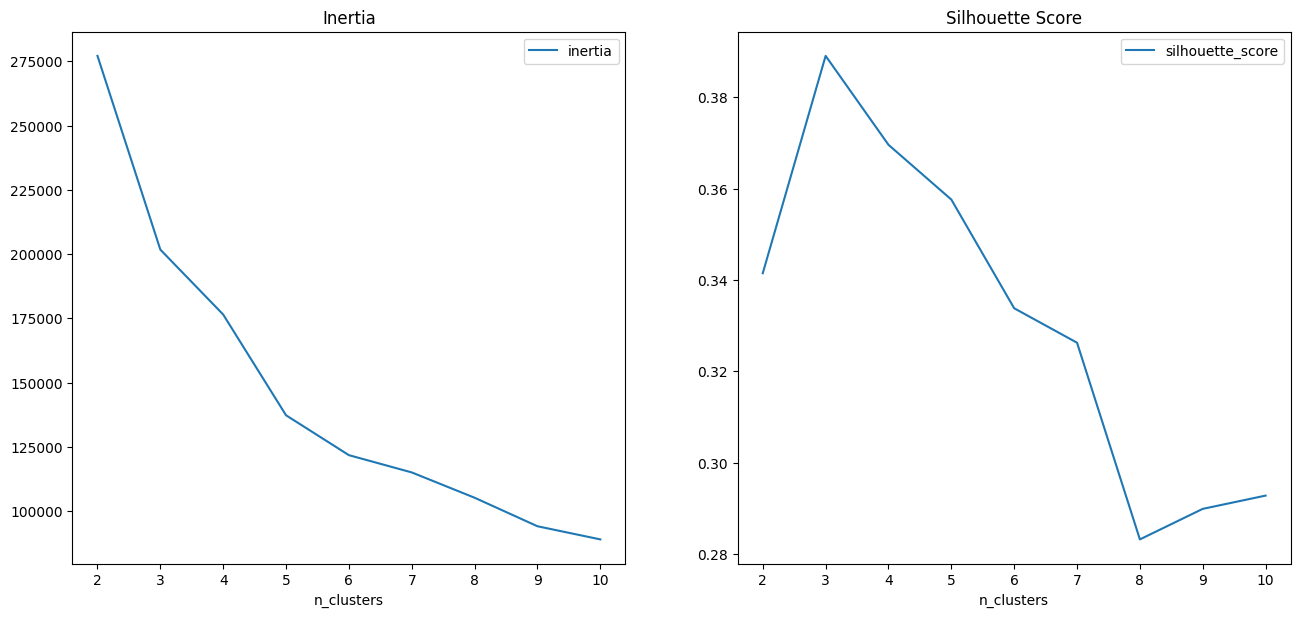

In [40]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
df_results.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
df_results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [41]:
model = df_results.loc[df_results.n_clusters==3, 'model'].iloc[0]
df_lifetime_cluster = df_lifetime.copy()
df_lifetime_cluster['cluster'] = model.labels_

In [42]:
cluster_centers = scaler.inverse_transform(model.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=df_lifetime.columns)
cluster_centers

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value
0,100.007495,378.069253,11.893924,2.662354,208.361014
1,829.981231,210.090314,165.511084,1.411884,81.470772
2,59.603875,392.130635,11.832873,1.207326,60.791028


In [43]:
df_lifetime_cluster['cluster'].value_counts()

cluster
2    46900
1    11602
0    10571
Name: count, dtype: int64

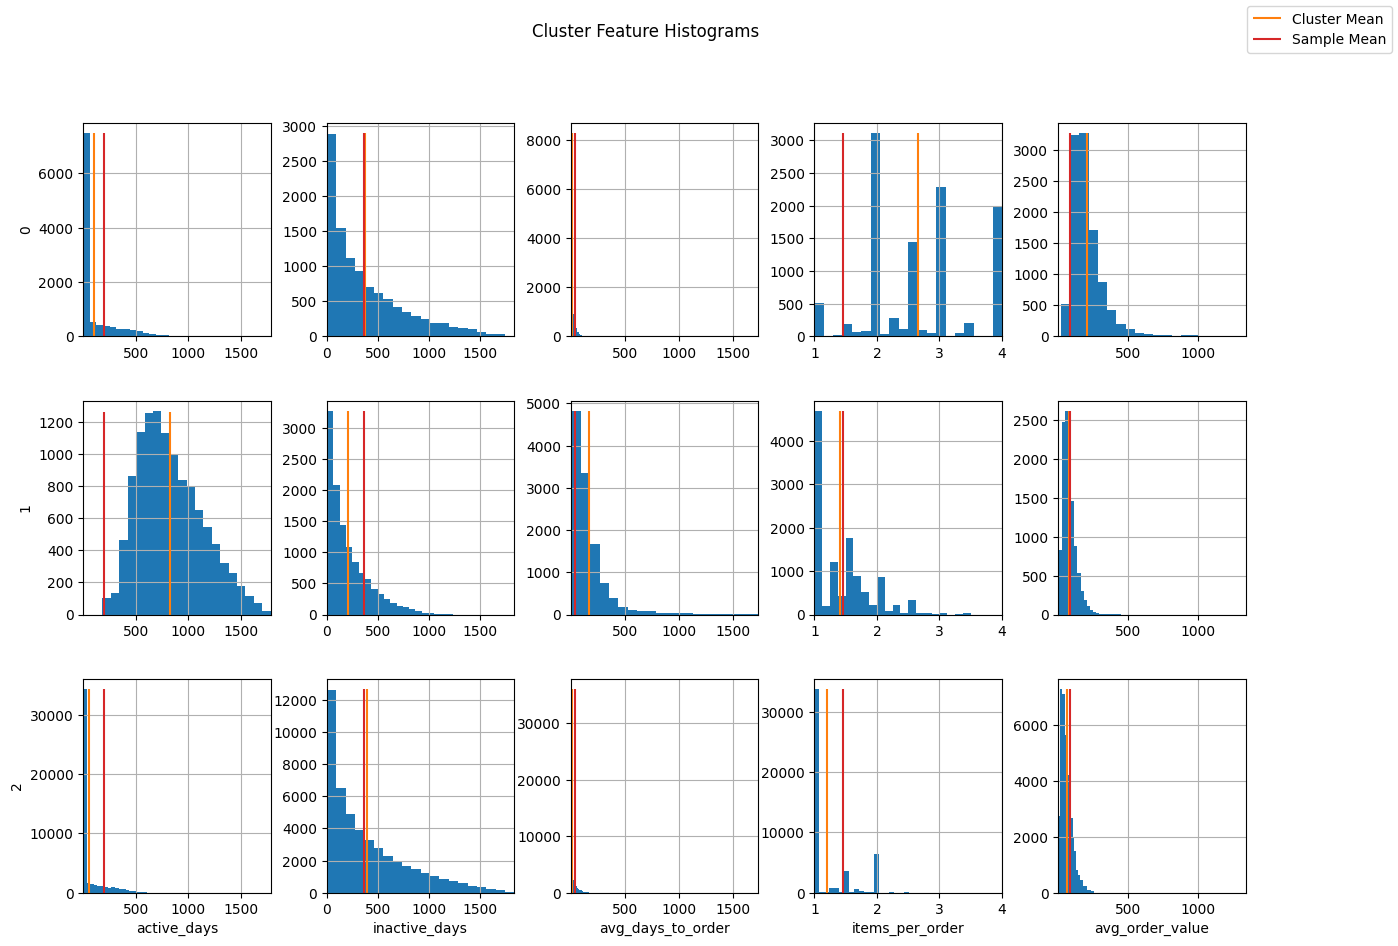

In [44]:
plot_clusters(df_lifetime, model.labels_)

In [45]:
print('Cluster Mean / Sample Mean:', df_lifetime_cluster.groupby('cluster').mean() / df_lifetime_cluster.drop(columns='cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', df_lifetime_cluster.groupby('cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', df_lifetime_cluster.groupby('cluster').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', df_lifetime_cluster.groupby('cluster').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', df_lifetime_cluster.groupby('cluster').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  inactive_days  avg_days_to_order  items_per_order  \
cluster                                                                   
0           0.513480       1.051745           0.316200         1.817506   
1           4.251112       0.584687           4.395281         0.964274   
2           0.305407       1.091076           0.314209         0.824576   

         avg_order_value  
cluster                   
0               2.398552  
1               0.938310  
2               0.700035  

--------------------------------------------------------------------------------

Cluster Mean:
         active_days  inactive_days  avg_days_to_order  items_per_order  \
cluster                                                                   
0         100.289187     377.969350          11.915702         2.660412   
1         830.296845     210.121014         165.631850         1.411477   
2          59.650000     392.104094          11.840648         1

In [47]:
cluster_2 = df_lifetime[model.labels_==2]
cluster_2

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value
1,1,6,1.000000,1.0,25.000
7,74,82,24.666667,1.0,45.750
9,1,71,1.000000,1.0,129.880
11,263,30,87.666667,1.0,37.225
12,1,124,1.000000,1.0,19.990
...,...,...,...,...,...
84001,1,732,1.000000,1.0,12.000
84002,192,476,38.400000,1.5,71.975
84005,1,1021,1.000000,1.0,44.990
84008,1,211,1.000000,1.0,16.990


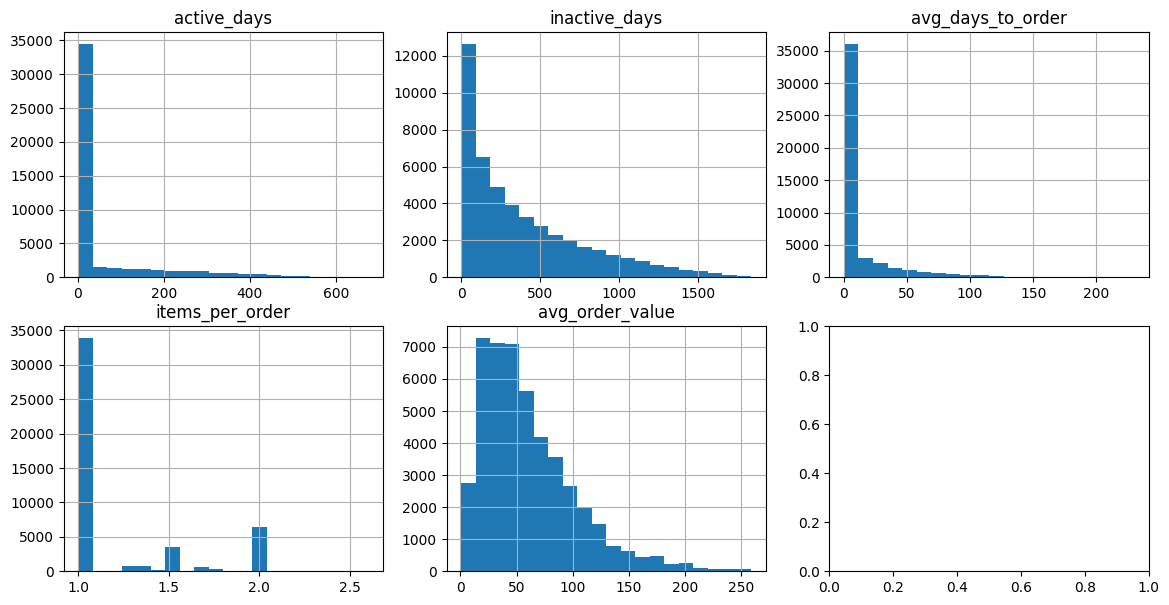

In [48]:
plot_histograms(cluster_2)

In [49]:
scaler_2 = StandardScaler()
X_2 = scaler_2.fit_transform(cluster_2)

In [50]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
df_results_2 = search_clustering_hyperparams(KMeans, hyperparams, X_2, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.35796939673655076 | Inertia: 174517.87548423238
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.29039094419003086 | Inertia: 135744.47152433934
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.3623097396554039 | Inertia: 101986.8643630015
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.36287487183124567 | Inertia: 91485.6341976164
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.3974342898595627 | Inertia: 69812.33314132811
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.3913965853815065 | Inertia: 64132.10153779902
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.3451159542319214 | Inertia: 59251.650137696524
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.34303137697550873 | Inertia: 55931.245517970034
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.33103771683796795 | Inertia: 51898.27419186275


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

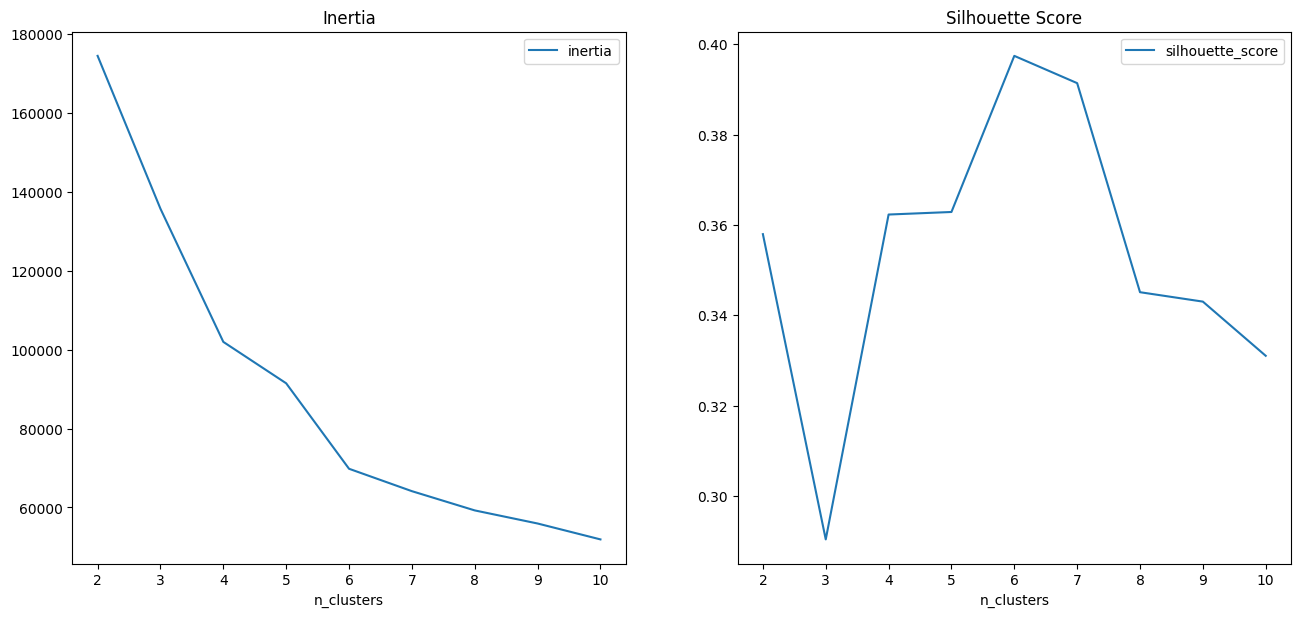

In [51]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
df_results_2.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
df_results_2.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [52]:
model_2 = df_results_2.loc[df_results.n_clusters==6, 'model'].iloc[0]
clustered_2 = cluster_2.copy()
clustered_2['cluster'] = model_2.labels_

In [53]:
clustered_2['cluster'].value_counts()

cluster
3    19576
1     7630
5     7057
0     4936
4     4612
2     3089
Name: count, dtype: int64

In [55]:
cluster_centers_2 = scaler_2.inverse_transform(model_2.cluster_centers_)
cluster_centers_2 = pd.DataFrame(cluster_centers_2, columns=df_lifetime.columns)
cluster_centers_2

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value
0,17.945591,338.585154,4.458092,1.056362,141.715714
1,7.366238,1001.429509,2.667629,1.018719,42.139280
2,267.799612,373.095824,85.317328,1.087953,55.395558
3,11.972065,208.833665,3.440599,1.017420,39.138408
4,312.838500,250.094515,33.070985,1.446573,76.831028
5,20.972927,381.499079,4.180232,1.937460,75.952471


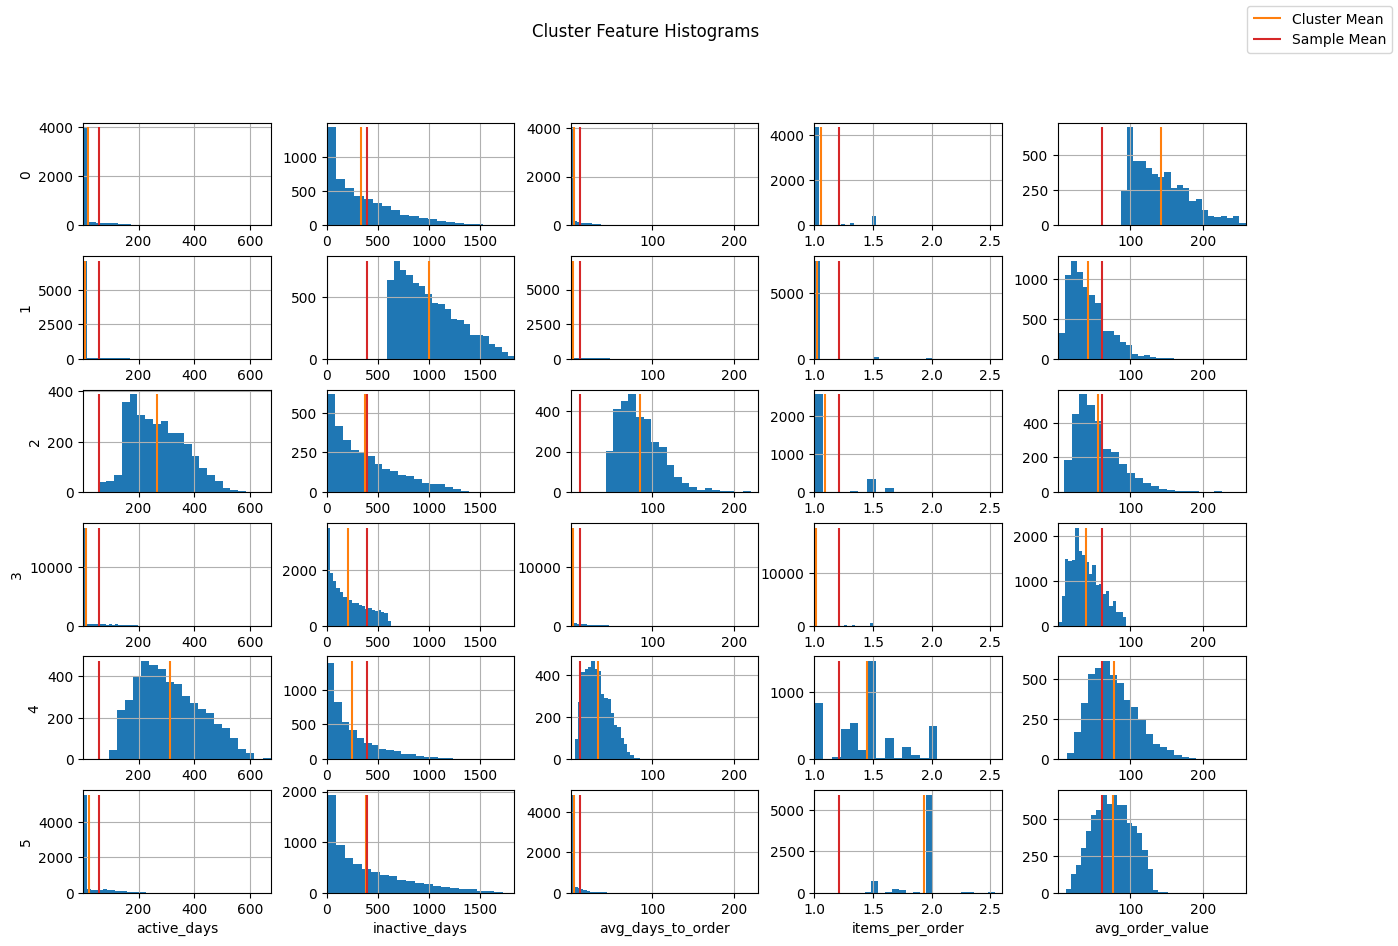

In [56]:
plot_clusters(cluster_2, model_2.labels_)

In [57]:
print('Cluster Mean / Sample Mean:', clustered_2.groupby('cluster').mean() / clustered_2.drop(columns='cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', clustered_2.groupby('cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', clustered_2.groupby('cluster').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', clustered_2.groupby('cluster').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', clustered_2.groupby('cluster').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  inactive_days  avg_days_to_order  items_per_order  \
cluster                                                                   
0           0.300711       0.863973           0.376247         0.875237   
1           0.123319       2.552067           0.225051         0.843882   
2           4.489516       0.951522           7.205461         0.901376   
3           0.200931       0.531932           0.290661         0.842974   
4           5.244804       0.637993           2.794036         1.198319   
5           0.352018       0.973271           0.353120         1.605208   

         avg_order_value  
cluster                   
0               2.333913  
1               0.693308  
2               0.911785  
3               0.644577  
4               1.264707  
5               1.250148  

--------------------------------------------------------------------------------

Cluster Mean:
         active_days  inactive_days  avg_days_to_order  it